# The Lenstra-Lenstra-Lovász (LLL) algorithm and its applications

This notebook provides an introduction to the Shortest Vector Problem (SVP) in lattices, the LLL algorithm and its applications in number theory, cryptography, and maybe even finance.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import itertools
import sympy as sp
from scipy.linalg import qr
from fractions import Fraction

## Lattice

A (full-rank) lattice $\Lambda$ in $\mathbb{R}^n$ is a subgroup of the additive group $\mathbb{R}^n$ of the form
$$ \Lambda = \left\{ \sum_{i=1}^n z_i \mathbf{b_i} \mid z_i \in \mathbb{Z} \right\} $$
where $\mathbf{B} = \left\{ \mathbf{b_1}, \ldots, \mathbf{b_n} \right\}$ is a basis of $\mathbb{R}^n$ (which is also the basis of the lattice).

A lattice can be visualized as a discrete grid in $\mathbb{R}^n$ formed by integer linear combinations of the basis vectors. The __fundamental region__ of the lattice is the parallelogram (in 2D) or parallelepiped (in 3D) spanned by the basis vectors.

The __determinant__ of the lattice, $\det(\Lambda)$, is the volume of the fundamental region of the lattice, given by $|\det(\mathbf{B})|$. The determinant is a measure of how "dense" the lattice is in space.

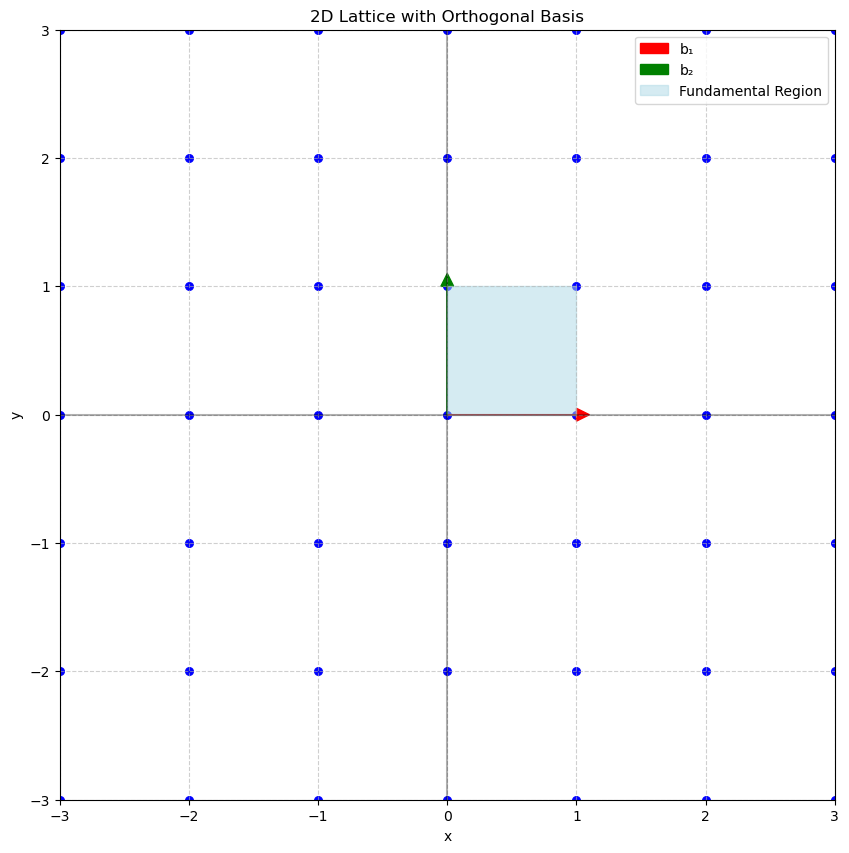

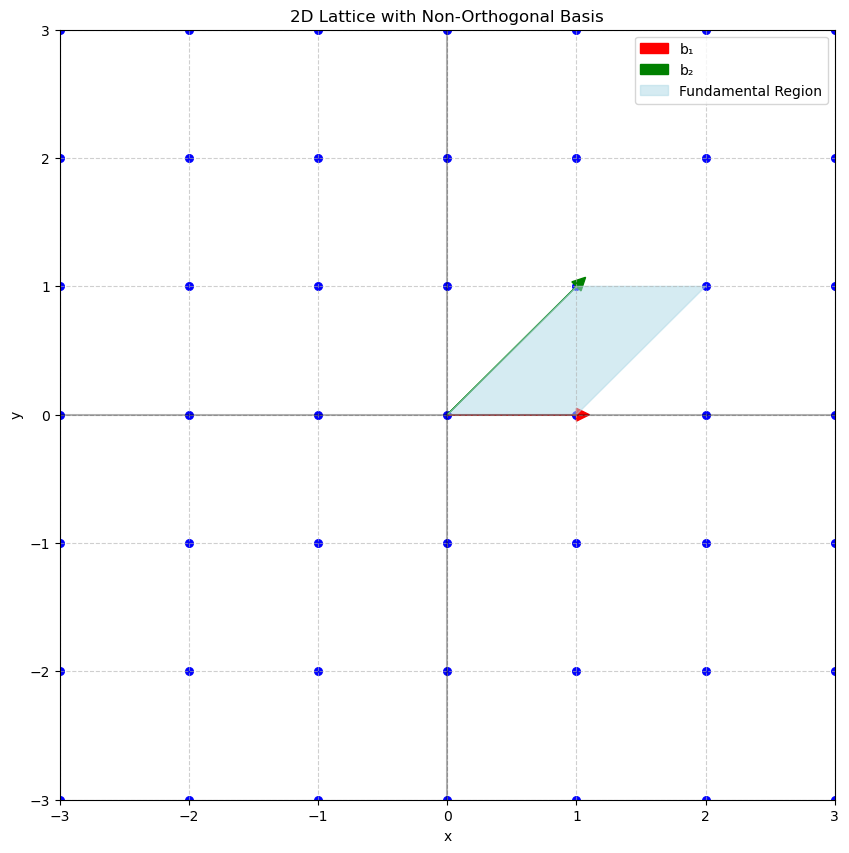

In [18]:
# Function to plot a 2D lattice
from sympy import li


def plot_2d_lattice(basis, limits=6, title="2D Lattice"):
    """Plot a 2D lattice with the given basis."""
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Generate lattice points
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append(point)
    
    # Convert to numpy array for easier manipulation
    points = np.array(points)
    
    # Plot the lattice points
    plt.scatter(points[:, 0], points[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='b₁')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label='b₂')
    
    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    # shade fundamental region of the lattice
    corners = np.array([
        [0, 0],
        basis[0],
        basis[0] + basis[1],
        basis[1]
    ])
    plt.fill(corners[:, 0], corners[:, 1], color='lightblue', alpha=0.5, label='Fundamental Region')

    # # Set equal aspect ratio
    # plt.axis('equal')
    plt.legend()
    plt.show()

# Example: Good basis
good_basis = np.array([[1, 0], [0, 1]])
plot_2d_lattice(good_basis, title="2D Lattice with Orthogonal Basis")

# Example: Bad basis
bad_basis = np.array([[1, 0], [1, 1]])
plot_2d_lattice(bad_basis, title="2D Lattice with Non-Orthogonal Basis")

# # Example: Very skewed basis
# skewed_basis = np.array([[1, 0], [20, 1]])
# plot_2d_lattice(skewed_basis, title="2D Lattice with Highly Skewed Basis")

## The Shortest Vector Problem (SVP)

SVP is NP-hard in general, but there are polynomial-time algorithms (such as the LLL algorithm) that can find _short_ vectors.

__Minkowski's theorem__ gives us a lower bound for the length of the shortest non-zero vector in an $n$-dimensional lattice:
$$ \lambda(\Lambda) \geq \sqrt{n} \cdot \det(\Lambda)^{1/n} $$
where $\lambda(\Lambda)$ is the length of the shortest non-zero vector in the lattice.

Algorithms like the LLL algorithm rely on finding a __short and nearly orthogonal basis__ for a given lattice. If we cannot reduce a basis further, then the shortest basis vector is the solution to the SVP.

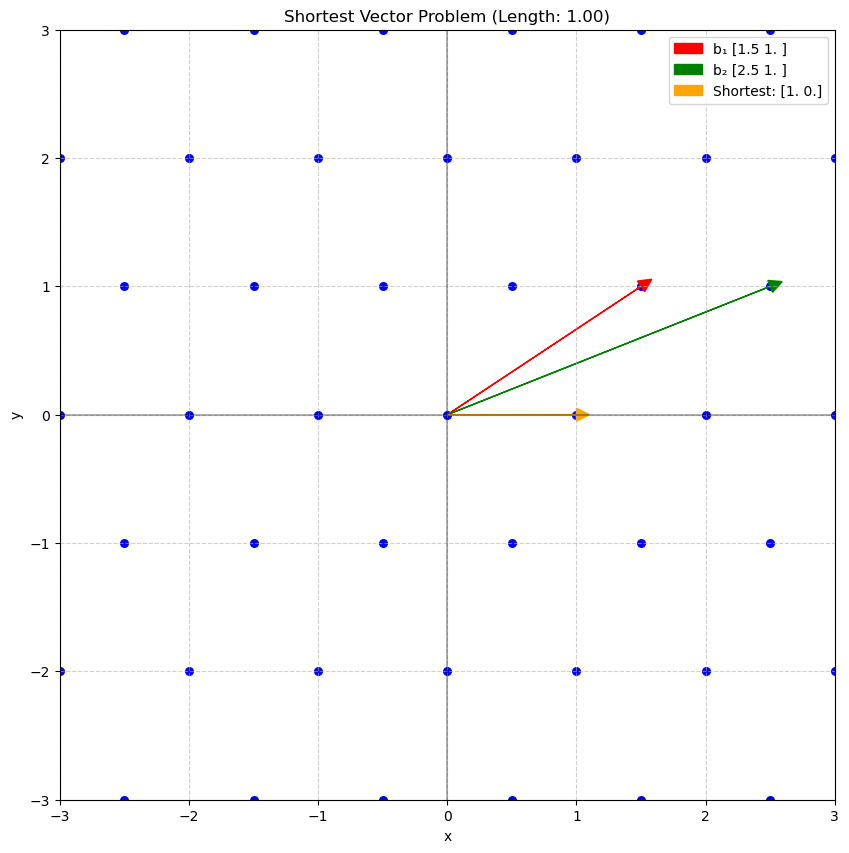

In [ ]:
# Visualise the shortest vector problem in 2D
def compute_vector_length(vector):
    """Compute the Euclidean length of a vector."""
    return np.sqrt(np.sum(vector**2))

def visualize_svp_2d(basis):
    """Visualize the shortest vector problem in 2D."""
    plt.figure(figsize=(10, 10))
    
    # Generate lattice points
    limits = 10
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append((point, i, j))
    
    # Find the shortest non-zero vector
    shortest_vector = None
    shortest_length = float('inf')
    
    for point, i, j in points:
        if i == 0 and j == 0:
            continue  # Skip the origin
        
        length = compute_vector_length(point)
        if length < shortest_length:
            shortest_length = length
            shortest_vector = point
    
    # Convert points to numpy array for plotting
    points_array = np.array([p[0] for p in points])
    
    # Plot the lattice points
    plt.scatter(points_array[:, 0], points_array[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label=f'b₁ {basis[0]}')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label=f'b₂ {basis[1]}')

    # Plot the shortest vector
    plt.arrow(0, 0, shortest_vector[0], shortest_vector[1], head_width=0.1, head_length=0.1, 
             fc='orange', ec='orange', label=f'Shortest: {shortest_vector}')
    
    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Shortest Vector Problem (Length: {shortest_length:.2f})")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    
    # # Set equal aspect ratio
    # plt.axis('equal')
    plt.show()

# # Example with a skewed basis
# skewed_basis = np.array([[1, 0], [0.3, 0.5]])
# visualize_svp_2d(skewed_basis)

# Another example
another_basis = np.array([[1.5, 1], [2.5, 1]])
visualize_svp_2d(another_basis)

## Basis reduction

For a 2D lattice with basis $\mathbf{B} = \{ \mathbf{b}_1, \mathbf{b}_2 \}$, we have an algorithm due to Lagrange which finds the shortest vector efficiently:
1. If $||\mathbf{b}_1|| > ||\mathbf{b}_2||$, swap them.
2. Compute $q = \left\lfloor \frac{\mathbf{b_1} \cdot \mathbf{b_2}}{||\mathbf{b_1}||^2} \right\rceil$ and $\mathbf{r} = \mathbf{b_2} - q \cdot \mathbf{b_1}$. Set $\mathbf{b_2} = \mathbf{b_1}$ and $\mathbf{b_1} = \mathbf{r}$.
3. If $||\mathbf{b_1}|| < ||\mathbf{b_2}||$, repeat step 2, else terminate and output $\mathbf{b_2}$.

To generalise this to higher dimensions, we need to adapt __Gram–Schmidt orthogonalization__. For a given basis $\mathbf{B} = \{ \mathbf{b_1}, \mathbf{b_2}, \ldots, \mathbf{b_m} \}$ of a subspace $H_m$ of $\mathbb{R}^n$, the standard Gram–Schmidt process produces the orthogonal basis $\mathbf{B}^* = \{ \mathbf{b_1}^*, \mathbf{b_2}^*, \ldots, \mathbf{b_m}^* \}$ as follows:
- $\mathbf{b_1}^* = \mathbf{b_1}$
- $\mathbf{b_2}^* = \mathbf{b_2} - u_{1,2} \mathbf{b_1}^*$ where $u_{1,2} = \frac{\mathbf{b_2} \cdot \mathbf{b_1}^*}{||\mathbf{b_1}^*||^2}$ \
$\vdots$
- $\mathbf{b_m}^* = \mathbf{b_m} - \sum_{i < m} u_{i,m} \mathbf{b_i}^*$ where $u_{i,m} = \frac{\mathbf{b_m} \cdot \mathbf{b_i}^*}{||\mathbf{b_i}^*||^2}$

### The LLL algorithm

1. Perform Gram–Schmidt orthogonalization but with:
$$ u_{i,m} = \left\lfloor \frac{\mathbf{b_m} \cdot \mathbf{b_i}^*}{||\mathbf{b_i}^*||^2} \right\rceil $$
on the basis $\mathbf{B}$ to obtain $\mathbf{B}^*$.

2. For each $i$ to $n-1$, check whether:
$$ ||\mathbf{b_{i+1}}^* + u_{i,i+1} \mathbf{b_i}^* ||^2 \geq \delta ||\mathbf{b_i}^*||^2. $$
If false for any $i$, then swap $\mathbf{b_i}$ and $\mathbf{b_{i+1}}$ and go to step 1. If true for all $i$, then terminate and output $\mathbf{B}^*$.

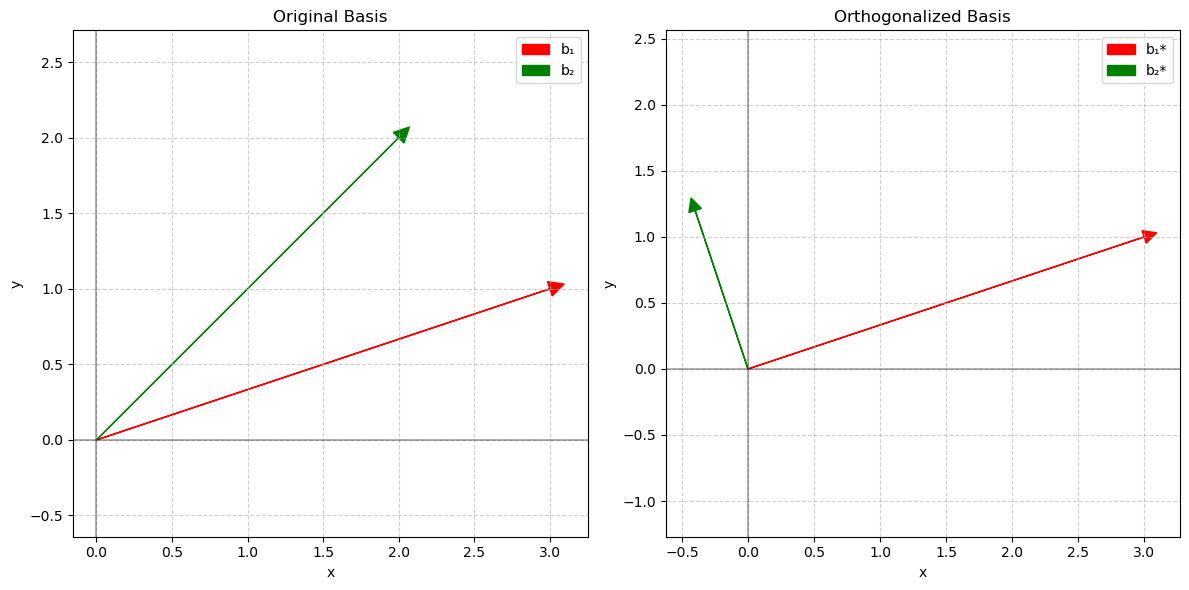

Gram-Schmidt Coefficients (μ):
[[0.  0. ]
 [0.8 0. ]]


In [5]:
def gram_schmidt(basis):
    """
    Perform Gram-Schmidt orthogonalization on a basis.
    
    Parameters:
    basis -- numpy array where each row is a basis vector
    
    Returns:
    orthogonal_basis -- orthogonalized basis
    mu -- coefficients from the orthogonalization process
    """
    n = len(basis)
    orthogonal_basis = np.zeros_like(basis, dtype=float)
    mu = np.zeros((n, n))
    
    # Copy the first vector
    orthogonal_basis[0] = basis[0]
    
    for i in range(n):
        # Start with the original vector
        orthogonal_basis[i] = basis[i].copy()
        
        # Subtract projections onto previous orthogonal vectors
        for j in range(i):
            # Calculate projection coefficient
            mu[i, j] = np.dot(basis[i], orthogonal_basis[j]) / np.dot(orthogonal_basis[j], orthogonal_basis[j])
            orthogonal_basis[i] = orthogonal_basis[i] - mu[i, j] * orthogonal_basis[j]
    
    return orthogonal_basis, mu

def visualize_gram_schmidt(basis):
    """Visualize the Gram-Schmidt process for a 2D basis."""
    # Calculate orthogonal basis
    orthogonal_basis, mu = gram_schmidt(basis)
    
    plt.figure(figsize=(12, 6))
    
    # Plot original basis
    plt.subplot(1, 2, 1)
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='b₁')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label='b₂')
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Original Basis")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    plt.axis('equal')
    
    # Plot orthogonal basis
    plt.subplot(1, 2, 2)
    plt.arrow(0, 0, orthogonal_basis[0][0], orthogonal_basis[0][1], head_width=0.1, head_length=0.1, 
             fc='red', ec='red', label='b₁*')
    plt.arrow(0, 0, orthogonal_basis[1][0], orthogonal_basis[1][1], head_width=0.1, head_length=0.1, 
             fc='green', ec='green', label='b₂*')
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Orthogonalized Basis")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Gram-Schmidt Coefficients (μ):")
    print(mu)

# Example
basis = np.array([[3, 1], [2, 2]])
visualize_gram_schmidt(basis)

2. The LLL Algorithm

The LLL (Lenstra-Lenstra-Lovász) algorithm is a polynomial-time lattice reduction algorithm that finds a reasonably good basis for a lattice.

LLL Algorithm Explanation
The LLL algorithm combines Gram-Schmidt orthogonalization with a size-reduction step and a swapping condition to produce a reduced basis. The key parameter is δ (typically 0.75), which controls the quality of the reduction.

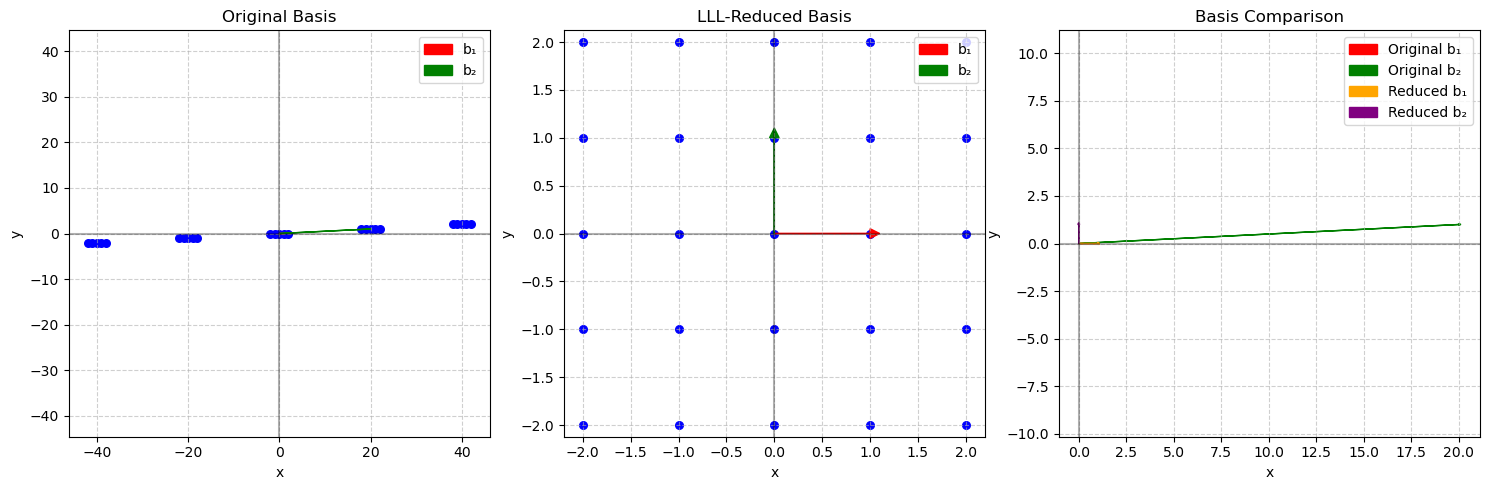

Original basis vector lengths:
  |b₁| = 1.0000
  |b₂| = 20.0250

Reduced basis vector lengths:
  |b₁'| = 1.0000
  |b₂'| = 1.0000

Orthogonality defect (closer to 1 is better):
  Original: 20.0250
  Reduced: 1.0000


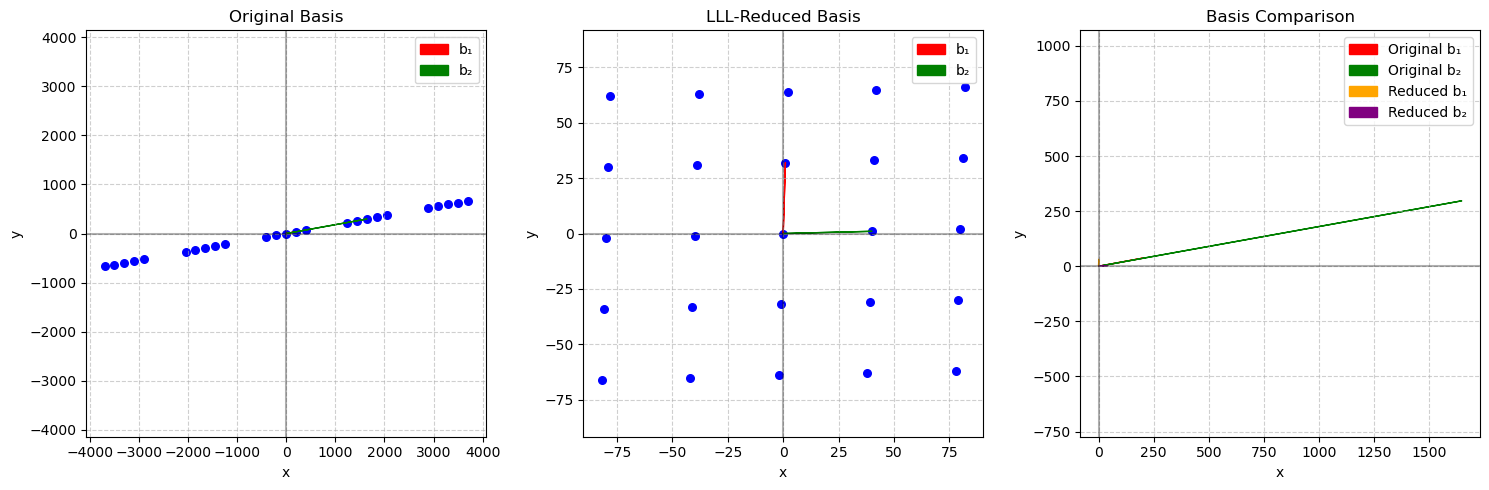

Original basis vector lengths:
  |b₁| = 204.3771
  |b₂| = 1674.5486

Reduced basis vector lengths:
  |b₁'| = 32.0156
  |b₂'| = 40.0125

Orthogonality defect (closer to 1 is better):
  Original: 267.5836
  Reduced: 1.0016


In [6]:
def lll_reduction(basis, delta=0.75):
    """
    Perform LLL lattice reduction on a basis.
    
    Parameters:
    basis -- numpy array where each row is a basis vector
    delta -- LLL parameter (typically 0.75)
    
    Returns:
    reduced_basis -- LLL-reduced basis
    """
    # Make a copy of the basis
    B = basis.copy().astype(float)
    n = len(B)
    
    # Initialize
    k = 1
    
    while k < n:
        # Gram-Schmidt orthogonalization
        B_star, mu = gram_schmidt(B)
        
        # Size reduction
        for j in range(k-1, -1, -1):
            if abs(mu[k, j]) > 0.5:
                # Round to nearest integer
                q = round(mu[k, j])
                B[k] = B[k] - q * B[j]
        
        # Calculate the orthogonalization again after size reduction
        B_star, mu = gram_schmidt(B)
        
        # Lovász condition
        lovasz_condition = delta * np.dot(B_star[k-1], B_star[k-1]) <= np.dot(B_star[k] + mu[k, k-1] * B_star[k-1], 
                                                                            B_star[k] + mu[k, k-1] * B_star[k-1])
        
        if lovasz_condition:
            k = k + 1
        else:
            # Swap vectors k and k-1
            B[[k, k-1]] = B[[k-1, k]]
            k = max(k-1, 1)
    
    return B

def visualize_lll_reduction(basis):
    """Visualize the LLL reduction process for a 2D basis."""
    # Perform LLL reduction
    reduced_basis = lll_reduction(basis)
    
    plt.figure(figsize=(15, 5))
    
    # Plot original basis and lattice
    plt.subplot(1, 3, 1)
    plot_2d_lattice_in_subplot(basis, limits=2, title="Original Basis")
    
    # Plot reduced basis and lattice
    plt.subplot(1, 3, 2)
    plot_2d_lattice_in_subplot(reduced_basis, limits=2, title="LLL-Reduced Basis")
    
    # Plot comparison of basis vectors
    plt.subplot(1, 3, 3)
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, 
             fc='red', ec='red', label='Original b₁')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, 
             fc='green', ec='green', label='Original b₂')
    
    plt.arrow(0, 0, reduced_basis[0][0], reduced_basis[0][1], head_width=0.1, head_length=0.1, 
             fc='orange', ec='orange', label='Reduced b₁')
    plt.arrow(0, 0, reduced_basis[1][0], reduced_basis[1][1], head_width=0.1, head_length=0.1, 
             fc='purple', ec='purple', label='Reduced b₂')
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Basis Comparison")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print some information about the reduction
    print("Original basis vector lengths:")
    print(f"  |b₁| = {compute_vector_length(basis[0]):.4f}")
    print(f"  |b₂| = {compute_vector_length(basis[1]):.4f}")
    
    print("\nReduced basis vector lengths:")
    print(f"  |b₁'| = {compute_vector_length(reduced_basis[0]):.4f}")
    print(f"  |b₂'| = {compute_vector_length(reduced_basis[1]):.4f}")
    
    # Calculate orthogonality defect
    original_defect = (compute_vector_length(basis[0]) * compute_vector_length(basis[1])) / np.abs(np.linalg.det(basis))
    reduced_defect = (compute_vector_length(reduced_basis[0]) * compute_vector_length(reduced_basis[1])) / np.abs(np.linalg.det(reduced_basis))
    
    print("\nOrthogonality defect (closer to 1 is better):")
    print(f"  Original: {original_defect:.4f}")
    print(f"  Reduced: {reduced_defect:.4f}")

def plot_2d_lattice_in_subplot(basis, limits=3, title="2D Lattice"):
    """Plot a 2D lattice with the given basis in a subplot."""
    # Generate lattice points
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append(point)
    
    # Convert to numpy array for easier manipulation
    points = np.array(points)
    
    # Plot the lattice points
    plt.scatter(points[:, 0], points[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='b₁')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label='b₂')
    
    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    
    # Set equal aspect ratio
    plt.axis('equal')

# Example with a highly skewed basis
skewed_basis = np.array([[1, 0], [20, 1]])
visualize_lll_reduction(skewed_basis)

# Another example
another_basis = np.array([[201, 37], [1648, 297]])
visualize_lll_reduction(another_basis)

Properties of LLL-Reduced Bases

The LLL algorithm guarantees the following properties for the reduced basis ${b_1, b_2, \ldots, b_n}$:

Size-reduced: $|\mu_{i,j}| \leq \frac{1}{2}$ for $1 \leq j < i \leq n$
Lovász condition: $\delta |b_i^|^2 \leq |b_{i+1}^ + \mu_{i+1,i}b_i^*|^2$ for $1 \leq i < n$
The algorithm produces a basis where:

The first vector $b_1$ is approximately short (within a factor of $2^{(n-1)/2}$ of the shortest vector)
The basis vectors are relatively orthogonal
The determinant of the lattice is preserved

3. Applications of LLL

Number Theory: Integer Relation Detection

LLL can be used to find integer relations among real numbers.

In [7]:
def integer_relation_detection(vector, precision=1e-10):
    """
    Find integer relations among real numbers using LLL.
    
    Parameters:
    vector -- list of real numbers
    precision -- desired precision
    
    Returns:
    relation -- list of integers such that dot(relation, vector) ≈ 0
    """
    n = len(vector)
    
    # Scale to handle floating point
    scale = 10**10
    scaled_vector = [x * scale for x in vector]
    
    # Create the lattice basis matrix
    basis = np.identity(n + 1, dtype=float)
    for i in range(n):
        basis[i, n] = scaled_vector[i]
    
    # Reduce the lattice
    reduced_basis = lll_reduction(basis)
    
    # Find a vector with a small last component
    best_relation = None
    min_last_component = float('inf')
    
    for i in range(n + 1):
        if abs(reduced_basis[i, n]) < precision * scale and abs(reduced_basis[i, n]) > 0:
            if abs(reduced_basis[i, n]) < min_last_component:
                min_last_component = abs(reduced_basis[i, n])
                best_relation = reduced_basis[i, :-1]
    
    if best_relation is not None:
        # Scale to integers and reduce
        best_relation = [int(round(x)) for x in best_relation]
        gcd_value = np.gcd.reduce(np.abs(best_relation))
        if gcd_value > 1:
            best_relation = [x // gcd_value for x in best_relation]
        
    return best_relation

# Example: Find relation for π, e, and √2
import math
vector = [math.pi, math.e, math.sqrt(2)]
relation = integer_relation_detection(vector)

print(f"Vector: {vector}")
print(f"Found relation: {relation}")
print(f"Verification: {sum(r * v for r, v in zip(relation, vector))}")

# Example: Find relation for the golden ratio φ
phi = (1 + math.sqrt(5)) / 2
vector = [1, phi, phi**2]
relation = integer_relation_detection(vector)

print(f"\nVector: {vector}")
print(f"Found relation: {relation}")
print(f"Verification: {sum(r * v for r, v in zip(relation, vector))}")
print(f"Expected relation: [1, -1, -1] (because φ² = φ + 1)")

Vector: [3.141592653589793, 2.718281828459045, 1.4142135623730951]
Found relation: [1, 0, 0]
Verification: 3.141592653589793

Vector: [1, 1.618033988749895, 2.618033988749895]
Found relation: [0, 1, 0]
Verification: 1.618033988749895
Expected relation: [1, -1, -1] (because φ² = φ + 1)


Cryptography: Breaking RSA with Small Exponents

LLL can be used to break RSA when the private exponent is small or when related messages are encrypted.

In [8]:
def simulate_rsa_attack(n, e, d_bits=None):
    """
    Simulate the attack on RSA when the private exponent d is small.
    
    Parameters:
    n -- RSA modulus
    e -- public exponent
    d_bits -- bit length of the private exponent d (if None, a small d is generated)
    
    Returns:
    d -- recovered private exponent
    success -- whether the attack was successful
    """
    # If d_bits is not specified, generate a small d
    if d_bits is None:
        # Generate a small d (using "d < N^0.25" which is considered insecure)
        d = np.random.randint(2, int(n**0.25))
    else:
        d = np.random.randint(2**(d_bits-1), 2**d_bits)
    
    # Ensure e*d ≡ 1 (mod φ(n))
    # Note: In real RSA, we would generate p, q, then φ(n), then e, then d.
    # Here we're working backwards for simplicity.
    k = 1
    while (e*d - 1) % k != 0 or (e*d - 1) // k >= n:
        k += 1
    
    phi_n = (e*d - 1) // k
    
    print(f"RSA Parameters:")
    print(f"  Modulus n = {n}")
    print(f"  Public exponent e = {e}")
    print(f"  Private exponent d = {d}")
    print(f"  φ(n) = {phi_n}")
    print(f"  k = {k} (where e*d = 1 + k*φ(n))")
    
    # Now simulate the attack using LLL
    # Set up the lattice for Wiener's attack
    matrix_dim = 2
    lattice_basis = np.zeros((matrix_dim, matrix_dim))
    
    # This is a simplified attack - in practice, continued fractions
    # or more complex lattice constructions would be used
    lattice_basis[0, 0] = n
    lattice_basis[0, 1] = e
    lattice_basis[1, 0] = 0
    lattice_basis[1, 1] = 1
    
    # Reduce the lattice
    reduced_basis = lll_reduction(lattice_basis)
    
    # The attack succeeds if we find a vector that leads to d
    success = False
    recovered_d = None
    
    for i in range(matrix_dim):
        # Check if the reduced vector leads to a potential d
        if reduced_basis[i, 1] != 0:
            potential_k = abs(reduced_basis[i, 0])
            potential_d = abs(reduced_basis[i, 1])
            
            # Verify if this is the correct d
            if (e * potential_d) % n == 1 or (e * potential_d - 1) % potential_k == 0:
                recovered_d = potential_d
                success = (recovered_d == d)
                break
    
    print(f"\nAttack result:")
    print(f"  Recovered d = {recovered_d}")
    print(f"  Attack {'successful' if success else 'failed'}")
    
    return recovered_d, success

# Example: Attack RSA with a small private exponent
n = 1000000000000037  # A large composite number
e = 65537              # Common RSA public exponent
recovered_d, success = simulate_rsa_attack(n, e, d_bits=20)

# Note: This is a simplified attack for illustration. Real attacks on RSA
# involve more complex lattice constructions and continued fractions.

RSA Parameters:
  Modulus n = 1000000000000037
  Public exponent e = 65537
  Private exponent d = 749741
  φ(n) = 49135775916
  k = 1 (where e*d = 1 + k*φ(n))

Attack result:
  Recovered d = None
  Attack failed


/tmp/ipykernel_17362/2539251243.py:63: RuntimeWarning: invalid value encountered in scalar remainder
  if (e * potential_d) % n == 1 or (e * potential_d - 1) % potential_k == 0:


Cryptography: Attacking Knapsack Cryptosystems

The LLL algorithm was famously used to break the Merkle-Hellman knapsack cryptosystem.

In [9]:
def generate_superincreasing_sequence(n, bit_length=20):
    """Generate a superincreasing sequence for the knapsack cryptosystem."""
    sequence = []
    total = 0
    
    for i in range(n):
        # Each element is greater than the sum of all previous elements
        next_value = total + np.random.randint(1, 100)
        sequence.append(next_value)
        total += next_value
    
    return sequence

def transform_knapsack(superincreasing_sequence, m, w):
    """Transform a superincreasing knapsack into a general knapsack."""
    return [(w * x) % m for x in superincreasing_sequence]

def knapsack_encrypt(message_bits, knapsack):
    """Encrypt a message using the knapsack cryptosystem."""
    if len(message_bits) != len(knapsack):
        raise ValueError("Message length must match knapsack length")
    
    return sum(bit * weight for bit, weight in zip(message_bits, knapsack))

def attack_knapsack(public_knapsack, ciphertext, n):
    """
    Attack a knapsack cryptosystem using LLL.
    
    Parameters:
    public_knapsack -- the public knapsack sequence
    ciphertext -- the encrypted message
    n -- length of the knapsack
    
    Returns:
    recovered_message -- the recovered plaintext bits
    """
    # Construct the lattice basis for the attack
    basis = np.zeros((n+1, n+1))
    
    # Set up the lattice according to the knapsack attack strategy
    for i in range(n):
        basis[i, i] = 2
        basis[i, n] = public_knapsack[i]
    
    basis[n, n] = ciphertext
    
    # Apply LLL reduction
    reduced_basis = lll_reduction(basis)
    
    # Look for a vector with entries close to ±1
    recovered_message = None
    
    for i in range(n+1):
        # Check if this row looks like a valid solution
        if all(abs(x) <= 1 for x in reduced_basis[i, :-1]) and reduced_basis[i, n] == 0:
            # Convert to binary (0 and 1)
            potential_message = [(1 - x) // 2 for x in reduced_basis[i, :-1]]
            
            # Verify this is the correct message
            if knapsack_encrypt(potential_message, public_knapsack) == ciphertext:
                recovered_message = potential_message
                break
    
    return recovered_message

# Example: Merkle-Hellman knapsack cryptosystem and attack
n = 8  # 8-bit message
message = [1, 0, 1, 0, 1, 1, 0, 1]  # Sample message

# Generate a superincreasing knapsack
superincreasing = generate_superincreasing_sequence(n)
print(f"Superincreasing sequence: {superincreasing}")

# Transform to a public knapsack
m = 2 * sum(superincreasing)  # Modulus must be larger than the sum
w = np.random.randint(2, m)  # Multiplier (must be coprime to m)
while np.gcd(w, m) != 1:
    w = np.random.randint(2, m)

public_knapsack = transform_knapsack(superincreasing, m, w)
print(f"Public knapsack: {public_knapsack}")

# Encrypt the message
ciphertext = knapsack_encrypt(message, public_knapsack)
print(f"Original message: {message}")
print(f"Ciphertext: {ciphertext}")

# Attack the knapsack
recovered_message = attack_knapsack(public_knapsack, ciphertext, n)
print(f"Recovered message: {recovered_message}")
print(f"Attack {'successful' if recovered_message == message else 'failed'}")

Superincreasing sequence: [46, 144, 258, 540, 1003, 2005, 4002, 8029]
Public knapsack: [6454, 3480, 22262, 13050, 5541, 13729, 16580, 31093]
Original message: [1, 0, 1, 0, 1, 1, 0, 1]
Ciphertext: 79079
Recovered message: None
Attack failed


Cryptography: Finding Small Solutions to Modular Equations

LLL can be used to find small solutions to modular equations, which has applications in cryptanalysis.

In [10]:
def find_small_solution(A, b, m, bound):
    """
    Find a small solution to the modular equation A*x ≡ b (mod m).
    
    Parameters:
    A -- list of coefficients
    b -- right-hand side of the equation
    m -- modulus
    bound -- upper bound on the solution size
    
    Returns:
    solution -- small solution if found, otherwise None
    """
    n = len(A)
    
    # Construct the lattice basis
    basis = np.zeros((n+1, n+1))
    
    # Set up the lattice
    for i in range(n):
        basis[i, i] = m
        basis[n, i] = A[i]
    
    basis[n, n] = 1
    
    # Apply LLL reduction
    reduced_basis = lll_reduction(basis)
    
    # Look for a solution
    solution = None
    
    for i in range(n+1):
        if reduced_basis[i, n] == 1 or reduced_basis[i, n] == -1:
            potential_solution = []
            for j in range(n):
                # Adjust sign if needed
                potential_solution.append(-reduced_basis[i, j] if reduced_basis[i, n] == -1 else reduced_basis[i, j])
            
            # Check bounds
            if all(abs(x) <= bound for x in potential_solution):
                # Verify solution
                result = sum(a * x for a, x in zip(A, potential_solution)) % m
                if result == b:
                    solution = potential_solution
                    break
    
    return solution

# Example: Find a small solution to a modular equation
A = [7, 13, 23]
b = 5
m = 101
bound = 10

solution = find_small_solution(A, b, m, bound)
print(f"Modular equation: {A[0]}x₁ + {A[1]}x₂ + {A[2]}x₃ ≡ {b} (mod {m})")
print(f"Found solution: {solution}")

if solution:
    result = sum(a * x for a, x in zip(A, solution)) % m
    print(f"Verification: {A[0]}*{solution[0]} + {A[1]}*{solution[1]} + {A[2]}*{solution[2]} ≡ {result} (mod {m})")

Modular equation: 7x₁ + 13x₂ + 23x₃ ≡ 5 (mod 101)
Found solution: None


Conclusion

The LLL algorithm is a powerful tool in computational number theory and cryptography. Its ability to find short, nearly orthogonal lattice bases has numerous applications:

Number Theory:

Finding integer relations among real numbers
Factoring polynomials
Solving Diophantine equations
Cryptography:

Breaking knapsack cryptosystems
Finding small solutions to modular equations
Attacking RSA with small exponents
Analysis of lattice-based cryptography
Computer Science:

Solving shortest vector problems (approximately)
Integer linear programming
GPS applications (for resolving integer ambiguities)
While the LLL algorithm provides polynomial-time approximations, it's important to note that exact solutions to the shortest vector problem remain NP-hard. This hardness forms the basis for lattice-based cryptography, which is considered quantum-resistant, making it increasingly important for post-quantum cryptographic systems.

In [11]:
# A complete implementation of the LLL algorithm
def complete_lll_reduction(basis, delta=0.75):
    """
    A complete implementation of the LLL algorithm.
    
    Parameters:
    basis -- numpy array where each row is a basis vector
    delta -- LLL parameter (typically 0.75)
    
    Returns:
    B -- LLL-reduced basis
    transformation -- transformation matrix from original to reduced basis
    """
    # Make a copy of the basis
    B = basis.copy().astype(float)
    n, m = B.shape
    
    # Initialize transformation matrix
    U = np.identity(n)
    
    # Initialize variables for Gram-Schmidt
    B_star = np.zeros((n, m))
    mu = np.zeros((n, n))
    
    def update_gram_schmidt(k):
        """Update the Gram-Schmidt orthogonalization up to index k."""
        for j in range(k+1):
            B_star[j] = B[j].copy()
            for i in range(j):
                mu[j, i] = np.dot(B[j], B_star[i]) / np.dot(B_star[i], B_star[i]) if np.dot(B_star[i], B_star[i]) != 0 else 0
                B_star[j] = B_star[j] - mu[j, i] * B_star[i]
    
    # Initial Gram-Schmidt
    update_gram_schmidt(n-1)
    
    # Main LLL algorithm
    k = 1
    while k < n:
        # Size reduction
        for j in range(k-1, -1, -1):
            if abs(mu[k, j]) > 0.5:
                q = round(mu[k, j])
                B[k] = B[k] - q * B[j]
                
                # Update transformation matrix
                U[k] = U[k] - q * U[j]
                
                # Update Gram-Schmidt
                update_gram_schmidt(k)
        
        # Lovász condition
        if delta * np.dot(B_star[k-1], B_star[k-1]) <= np.dot(B_star[k], B_star[k]) + mu[k, k-1]**2 * np.dot(B_star[k-1], B_star[k-1]):
            k = k + 1
        else:
            # Swap vectors k and k-1
            B[[k, k-1]] = B[[k-1, k]]
            U[[k, k-1]] = U[[k-1, k]]
            
            # Update Gram-Schmidt
            update_gram_schmidt(k)
            
            k = max(k-1, 1)
    
    return B, U

# Example usage
basis = np.array([[201, 37], [1648, 297]])
reduced_basis, transformation = complete_lll_reduction(basis)

print("Original basis:")
print(basis)
print("\nLLL-reduced basis:")
print(reduced_basis)
print("\nTransformation matrix:")
print(transformation)
print("\nVerification: transformation * original = reduced")
print(np.dot(transformation, basis))

Original basis:
[[ 201   37]
 [1648  297]]

LLL-reduced basis:
[[ 1. 32.]
 [40.  1.]]

Transformation matrix:
[[41. -5.]
 [-8.  1.]]

Verification: transformation * original = reduced
[[ 1. 32.]
 [40.  1.]]
